# Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data

First, we need to specify the directories and load the data.

In [26]:
res = '5.625'
DATADIR = f'/data/WeatherBench/{res}deg/'  # Location of WeatherBench dataset
PREDDIR = '/data/WeatherBench/baselines/'   # Location to store baseline forecasts

In [10]:
!ls $DATADIR

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants		 temperature		       v_component_of_wind
geopotential		 temperature_850	       vorticity
geopotential_500	 toa_incident_solar_radiation


In [12]:
xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords')

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [14]:
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
tp = xr.open_mfdataset(f'{DATADIR}total_precipitation/*.nc', combine='by_coords').tp
t2m = xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords').t2m
data = xr.merge([z500, t850, tp, t2m])

In [19]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp')
t2m_valid = load_test_data(f'{DATADIR}2m_temperature', 't2m')
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid])

## Persistence

Persistence simply means: Tomorrow's weather is today's weather.

In [21]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [22]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [23]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [24]:
persistence

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
Data variables:
    z          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    t          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    tp         (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>
    t2m        (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 32, 64), meta=np.ndarray>

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [27]:
# Save the predictions
persistence.to_netcdf(f'{PREDDIR}persistence_{res}.nc')

## Climatology

First let's create a single climatology from the entire training dataset (meaning everything before 2017).

In [28]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [29]:
train_data = data.sel(time=slice(None, '2016'))

In [30]:
climatology = create_climatology_forecast(train_data)

In [31]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
Data variables:
    z        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    t        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    tp       (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    t2m      (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>

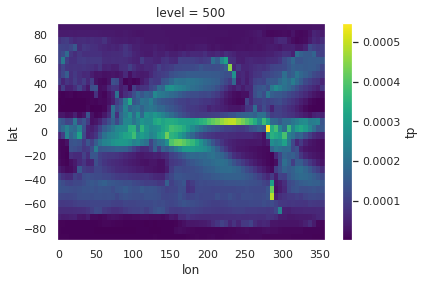

In [38]:
climatology.tp.plot();

In [33]:
climatology.to_netcdf(f'{PREDDIR}climatology_{res}.nc')

## Climatology by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [34]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [35]:
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

In [36]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>

In [37]:
weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology_{res}.nc')

# The same for higher resolutions

Not up to date, but previous tests for Z500 and T850 showed that there was only a tiny difference in the scores for different resolutions.

In [ ]:
for res in ['2.8125','1.40625']:
    DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
    # Load the entire dataset
    z500 = xr.open_mfdataset(f'{DATADIR}geopotential/*.nc', combine='by_coords').z.sel(level=500)
    t850 = xr.open_mfdataset(f'{DATADIR}temperature/*.nc', combine='by_coords').t.sel(level=850)
    data = xr.merge([z500.drop('level'), t850.drop('level')])
    # Load the validation subset of the data: 2017 and 2018
    z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
    t850_valid = load_test_data(f'{DATADIR}temperature', 't')
    valid_data = xr.merge([z500_valid, t850_valid])
    # Persistence forecast
    persistence = []
    for l in lead_times:
        persistence.append(create_persistence_forecast(valid_data, int(l)))
    persistence = xr.concat(persistence, dim=lead_times)
    print(persistence)
    persistence.to_netcdf(f'{PREDDIR}persistence_{res}.nc')
    # Climatology
    train_data = data.sel(time=slice(None, '2016'))
    climatology = create_climatology_forecast(train_data)
    print(climatology)
    climatology.to_netcdf(f'{PREDDIR}climatology_{res}.nc')
    # Weekly climatology
    weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)
    print(weekly_climatology)
    weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology_{res}.nc')

# The End